In [1]:
%pylab inline
from utils import *
from ipdb import set_trace
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
# from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
gpu = True
workers = 4

LAMBDA= 10
_eps = 1e-15
Use_BRATS=False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 0
gpu_1 = 0
torch_seed = 42
# r_g = torch.manual_seed(torch_seed)

In [3]:
dataset = ADNIdataset(augmentation=True, img_size=64)
# trainset, testset = data.random_split(dataset, [5, 5], generator=r_g)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
# test_loader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)
# if Use_BRATS:
#     #'flair' or 't2' or 't1ce'
#     trainset = BRATSdataset(imgtype='flair')
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [4]:
def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images

In [5]:
G = Generator(noise = latent_dim)
CD = Code_Discriminator(code_size = latent_dim ,num_units = 4096)
D = Discriminator(is_dis=True)
E = Discriminator(out_class = latent_dim,is_dis=False, img_size=128)

G.cuda(gpu_0)
D.cuda(gpu_0)
CD.cuda(gpu_1)
E.cuda(gpu_1)

Discriminator(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv3d(512, 1000, kernel_size=(4, 4, 4), stride=(1, 1, 1))
  (bn5): BatchNorm3d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv3d(1000, 1000, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

In [6]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)

In [7]:
def calc_gradient_penalty(model, x, x_gen, w=10, cuda_ind=0):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_().cuda(cuda_ind)
    #x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = x*alpha + x_gen*(1-alpha)
    # x_hat = Variable(x_hat, requires_grad=True)
    x_hat.requires_grad = True

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2
    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

# Training

In [8]:
torch.autograd.set_detect_anomaly(True)
#remove Variable usage
# real_y = torch.ones((BATCH_SIZE, 1)).cuda()#async=True))
# fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()#async=True))

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [9]:
# load the highest savepoints of all models
iteration = load_checkpoint(G, D, E, CD, '_iter')
df = load_loss()

In [10]:
g_iter = 1
d_iter = 3
cd_iter =1
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)
test_load = inf

lossStr [164500/200000]
        D: -4.91   
        En_Ge: -4.56e+06
        Code: 42.1    


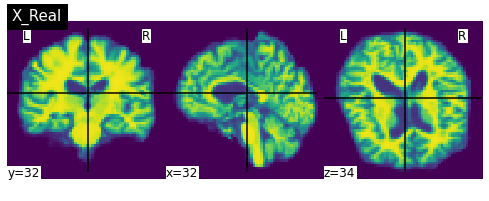

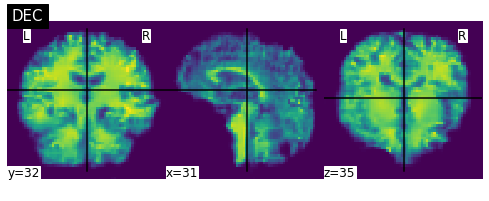

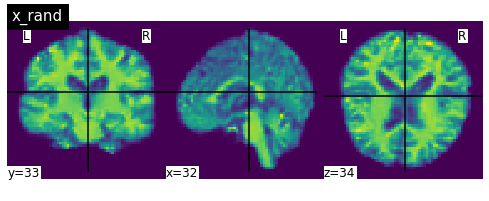

<Figure size 432x288 with 0 Axes>

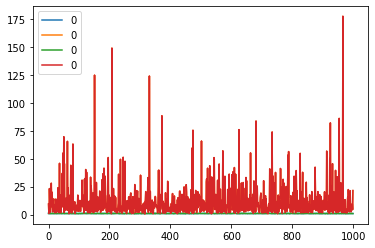

index: 164500, sample_mean: -0.2986980378627777 sample_var: 299.0115966796875, yellow_mean: -4.755327245220542e-05 yellow_var: 1.0015621185302734


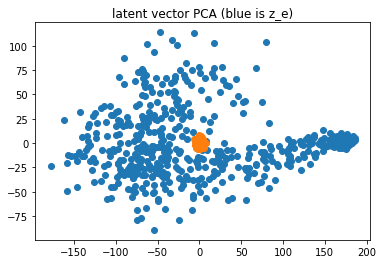

index: 164500, sample_mean: -0.856664776802063 sample_var: 0.059460654854774475, yellow_mean: -0.8587362766265869 yellow_var: 0.05640428140759468


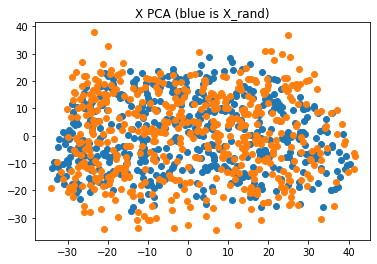


Count: 164500 Mean: 1285.780493951613
lossStr [164600/200000]
        D: -23.2   
        En_Ge: -4.56e+06
        Code: 74.1    


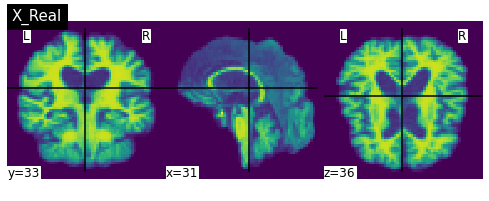

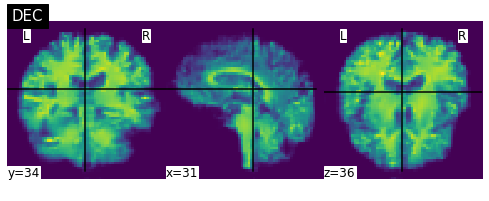

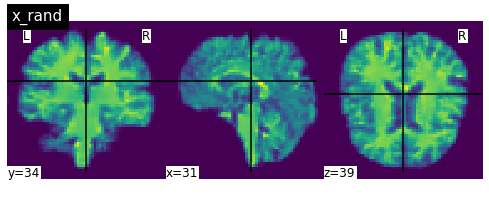

lossStr [164700/200000]
        D: -36.9   
        En_Ge: -4.57e+06
        Code: 64.6    


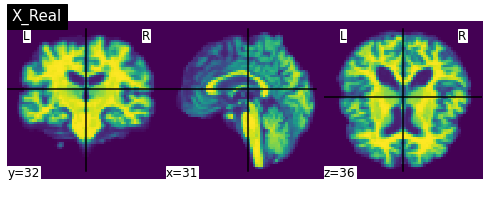

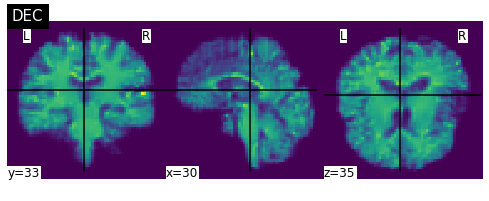

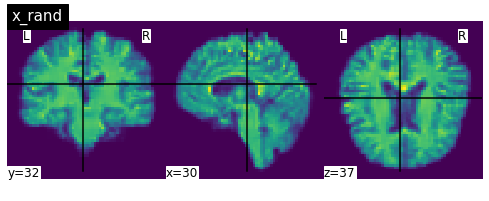

lossStr [164800/200000]
        D: -12.2   
        En_Ge: -4.57e+06
        Code: 78.5    


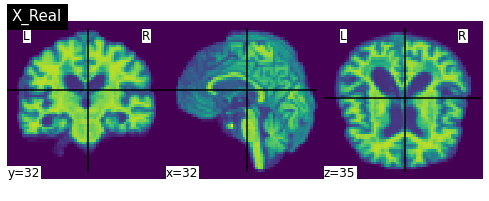

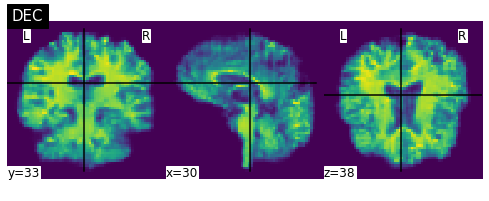

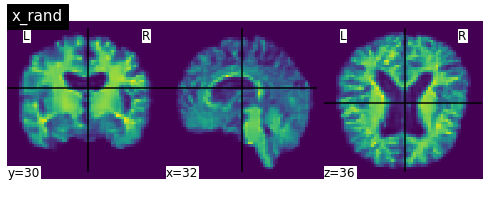

lossStr [164900/200000]
        D: -38.4   
        En_Ge: -4.58e+06
        Code: 40.1    


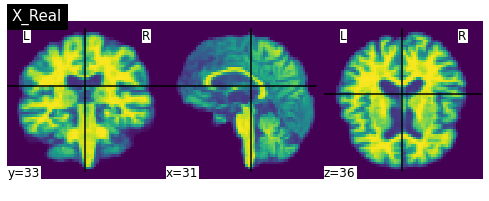

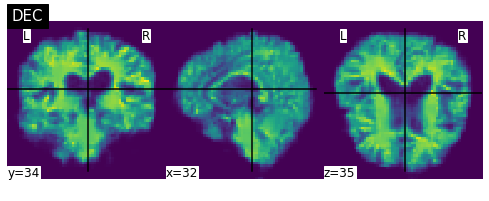

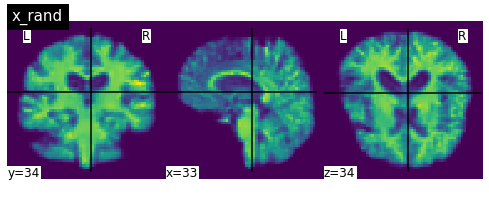

lossStr [165000/200000]
        D: -32.6   
        En_Ge: -4.58e+06
        Code: 38.0    


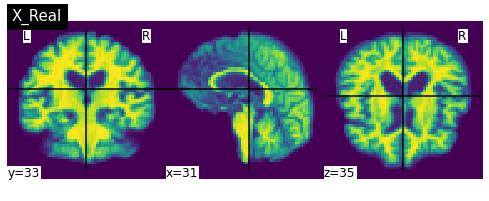

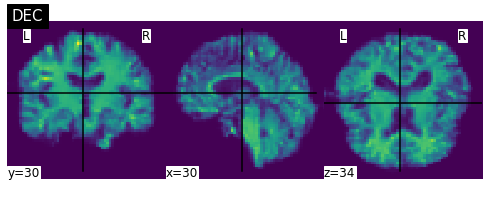

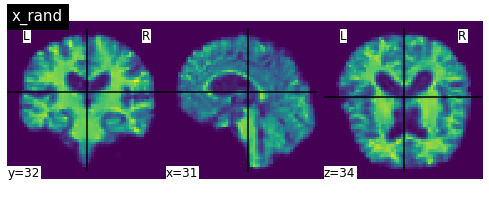

<Figure size 432x288 with 0 Axes>

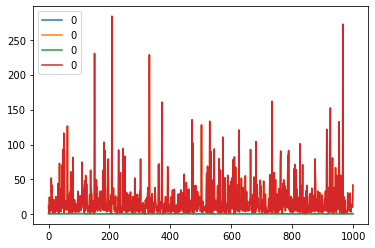

index: 165000, sample_mean: -0.304940402507782 sample_var: 326.6832580566406, yellow_mean: -0.0004695923416875303 yellow_var: 1.0014500617980957


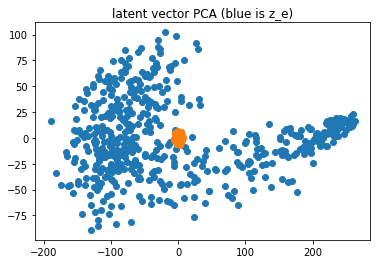

index: 165000, sample_mean: -0.8610168695449829 sample_var: 0.055366650223731995, yellow_mean: -0.8596383929252625 yellow_var: 0.055711060762405396


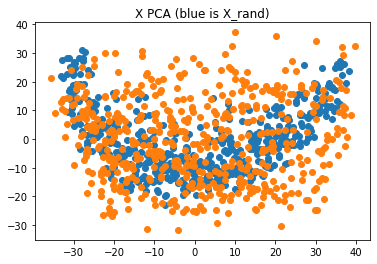


Count: 165000 Mean: 1224.274445564516
lossStr [165100/200000]
        D: -58.6   
        En_Ge: -4.59e+06
        Code: 48.1    


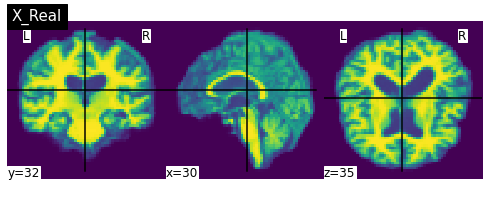

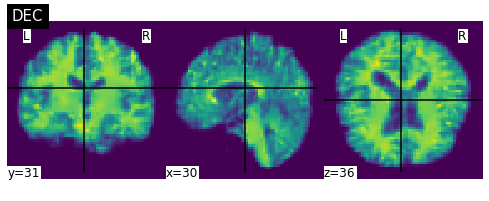

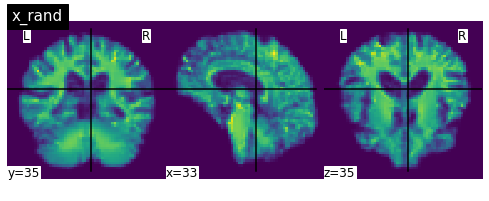

lossStr [165200/200000]
        D: -24.4   
        En_Ge: -4.59e+06
        Code: 1.95e+02


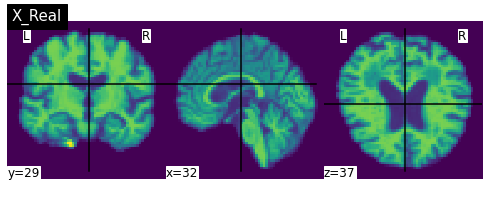

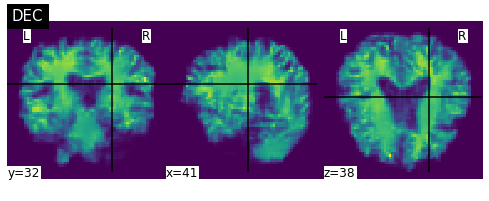

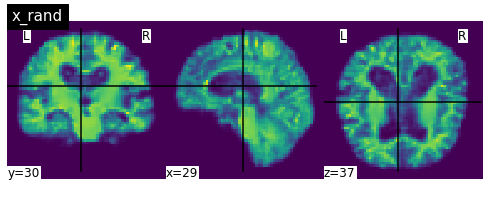

lossStr [165300/200000]
        D: -82.4   
        En_Ge: -4.6e+06
        Code: 37.7    


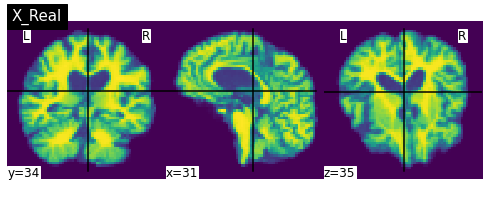

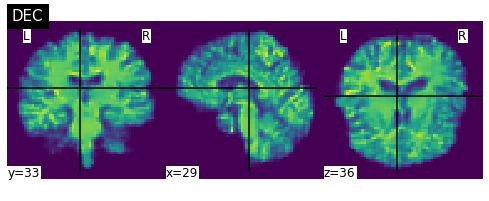

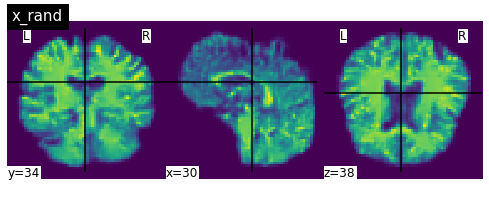

lossStr [165400/200000]
        D: -48.3   
        En_Ge: -4.61e+06
        Code: 78.1    


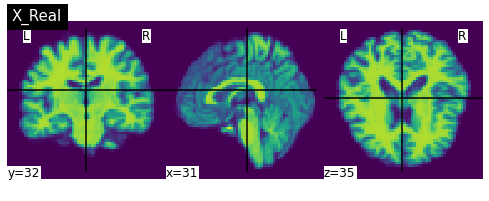

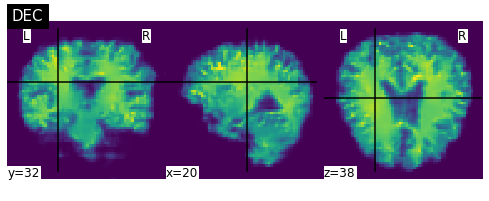

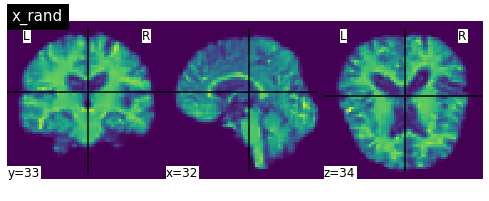

lossStr [165500/200000]
        D: -38.8   
        En_Ge: -4.61e+06
        Code: 74.4    


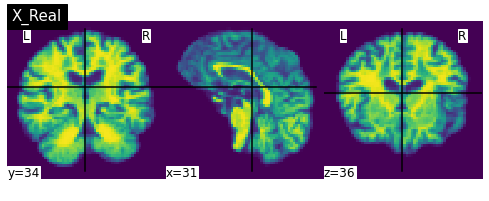

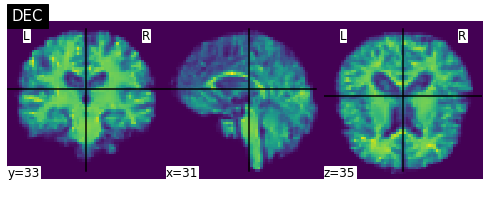

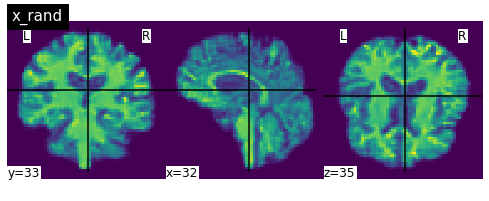

<Figure size 432x288 with 0 Axes>

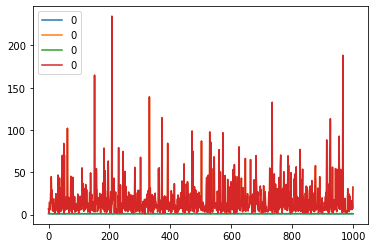

index: 165500, sample_mean: -0.6454699039459229 sample_var: 332.404541015625, yellow_mean: -0.0015942074824124575 yellow_var: 1.0015232563018799


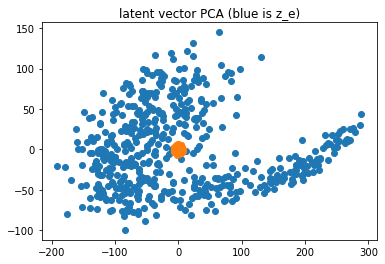

index: 165500, sample_mean: -0.8525360226631165 sample_var: 0.06061078608036041, yellow_mean: -0.8582553267478943 yellow_var: 0.05675230920314789


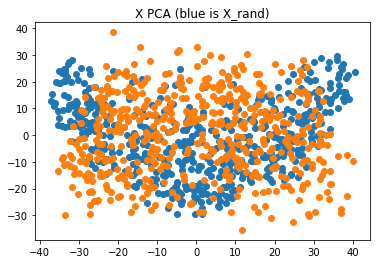


Count: 165500 Mean: 1395.885710685484


In [ ]:
g_iter = 1
d_iter = 3
cd_iter =1
TOTAL_ITER = 100000
gen_load = inf_train_gen(train_loader)


while iteration <= TOTAL_ITER:
    for p in D.parameters():  
        p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters():  
        p.requires_grad = True

    ###############################################
    # Train Encoder - Generator 
    ###############################################
    for iters in range(g_iter):
        G.zero_grad()
        E.zero_grad()
        real_images = gen_load.__next__()
        _batch_size = real_images.size(0)
        #remove Volatile Variable Usage
        real_images = real_images.cuda(gpu_1)
        
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        
        ### MMD between z_e and z_r ###################
        #mmd_loss = 0.1 * latent_mmd(E, gen_load, batch_size=BATCH_SIZE)
        ###############################################
        
#         c_loss = -1 * CD(z_hat.cuda(gpu_1)).mean() 
        d_real_loss = D(x_hat.cuda(gpu_0)).mean()
        d_fake_loss = D(x_rand.cuda(gpu_0)).mean()
        d_loss = -d_fake_loss-d_real_loss
        l1_loss = 10 * criterion_l1(x_hat.cuda(gpu_1),real_images) #original weight for L1 loss: 10
        loss1 = l1_loss + d_loss.cuda(gpu_1) + c_loss # mmd_loss # original weight for c_loss: 1
        
        if iters<g_iter-1:
            loss1.backward()
        else:
            loss1.backward(retain_graph=True)
        e_optimizer.step() 
        g_optimizer.step()
        g_optimizer.step()
    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for iters in range(d_iter):
        d_optimizer.zero_grad()
        real_images = gen_load.__next__()
        _batch_size = real_images.size(0)
        #remove Volatile Variable
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        real_images = real_images.cuda(gpu_1)
        z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        real_images = real_images.cuda(gpu_0)
        x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
        
        gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand)
        gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat)

        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
        loss2.backward(retain_graph=True)
        d_optimizer.step()

    ###############################################
    # Train CD
    ###############################################
#     for p in D.parameters():  
#         p.requires_grad = False
#     for p in CD.parameters():  
#         p.requires_grad = True
#     for p in E.parameters():  
#         p.requires_grad = False
#     for p in G.parameters():  
#         p.requires_grad = False
        
#     for iters in range(cd_iter):
#         cd_optimizer.zero_grad()
#         #remove volatile Variable usage
#         z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_1)
#         z_rand.requires_grad = False
        
#         gradient_penalty_cd = calc_gradient_penalty(CD,z_hat.cuda(gpu_1), z_rand, cuda_ind=gpu_1)
#         cd_zrand_loss = -CD(z_rand).mean()
#         loss3 = cd_zrand_loss - c_loss + gradient_penalty_cd
#         loss3.backward()
#         cd_optimizer.step()

    ###############################################
    # Visualization
    ###############################################

    if iteration % 100 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(loss2.item()) + '\n\
        En_Ge: {:<8.3}'.format(loss1.item()) + '\n\
        Code: {:<8.3}'.format(loss3.item()) 
        
        print('lossStr', lossStr)
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        
        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        
    ###############################################
    # Save the losses
    ###############################################
    loss_dict = {
        'index': [iteration],
        'l1_loss': [l1_loss.item()],
        'd_recon': [d_real_loss.item()],
        'd_fake': [d_fake_loss.item()],
        'd_real': [-2*D(real_images).mean().item()],
#         'mmd_loss': [mmd_loss.item()],
        'd_loss': [d_loss.item()],
        'cd_loss': [c_loss.item()],
        'cd_zrand_loss': [cd_zrand_loss.item()],
        'gp_r': [gradient_penalty_r.item()],
        'gp_h': [gradient_penalty_h.item()],
        'gp_cd': [gradient_penalty_cd.item()],
        'loss1': [loss1.item()],
        'loss2': [loss2.item()],
        'loss3': [loss3.item()],
    }
    df = add_loss(df, loss_dict)
        

    ###############################################
    # Model Save
    ###############################################
    if iteration % 500 == 0 and iteration != 0:
        torch.save(G.state_dict(),'./checkpoint/G_iter'+str(iteration)+'.pth')
        torch.save(D.state_dict(),'./checkpoint/D_iter'+str(iteration)+'.pth')
        torch.save(E.state_dict(),'./checkpoint/E_iter'+str(iteration)+'.pth')
        torch.save(CD.state_dict(),'./checkpoint/CD_iter'+str(iteration)+'.pth')
        viz_pca(E, dataset, latent_size=latent_dim, index=iteration, is_cd=True)
        viz_pca(G, dataset, latent_size=latent_dim, index=iteration)
        calc_mmd(train_loader, G, iteration, gpu_ind=gpu_1)
        
        write_loss(df)
        
    iteration += 1
   
    

In [ ]:
torch.normal(0.0, 3 ** 0.5, size=(10, 1000))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%debug

In [ ]:
!kill `lsof -i:8008 -t`